# Predicting Premier League Match Winners From Game Data

In this project we will be predicting the winner of premier league matches using a dataset that contains data from the 2020-2021 and 2021-2022 seasons. The data was scraped partway through the 2021-2022 season and therefore does not have a complete match history for that season.

The prediction will use a games post match data, to see how well it can predict which team won the game. The motivation for this project is mainly out of interest to see how well a games result can be predicted from basic post-match statistics.

# 1. Getting Set Up

In [141]:
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [142]:
# Reading in the data
matches = pd.read_csv("matches.csv", index_col=0)

In [143]:
# Looking at the first few rows of the dataset
pd.set_option('display.max_columns', None)
print(f'There are {matches.shape[0]} rows (or number of games) and {matches.shape[1]} columns in the dataset')
matches.head()

There are 1389 rows (or number of games) and 27 columns in the dataset


,date,time,comp,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,1.9,1.3,64.0,58262.0,Fernandinho,4-3-3,Anthony Taylor,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,2.7,0.1,67.0,51437.0,İlkay Gündoğan,4-3-3,Graham Scott,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,3.8,0.1,80.0,52276.0,İlkay Gündoğan,4-3-3,Martin Atkinson,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,2.9,0.8,61.0,32087.0,İlkay Gündoğan,4-3-3,Paul Tierney,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,1.1,0.4,63.0,52698.0,Fernandinho,4-3-3,Jonathan Moss,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


Observations:
- Can see columns which may be redundant: `comp`, `match report`, `notes`

Lets have a closer look at these columns

In [144]:
# checking different values and their frequencies for the `comp`, `match report` and `notes` columns
print(matches['comp'].value_counts())
print('_'*30)
print(matches['match report'].value_counts())
print('_'*30)
print(matches['notes'].value_counts(dropna=False))

Premier League    1389
Name: comp, dtype: int64
______________________________
Match Report    1389
Name: match report, dtype: int64
______________________________
NaN    1389
Name: notes, dtype: int64


I will remove all these features as every row contains the same information they are all redundant

In [145]:
# Dropping the columns that have the same value for every row
matches = matches.drop(['comp', 'match report', 'notes'], axis=1)

In [146]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 1 to 42
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1389 non-null   object 
 1   time        1389 non-null   object 
 2   round       1389 non-null   object 
 3   day         1389 non-null   object 
 4   venue       1389 non-null   object 
 5   result      1389 non-null   object 
 6   gf          1389 non-null   float64
 7   ga          1389 non-null   float64
 8   opponent    1389 non-null   object 
 9   xg          1389 non-null   float64
 10  xga         1389 non-null   float64
 11  poss        1389 non-null   float64
 12  attendance  693 non-null    float64
 13  captain     1389 non-null   object 
 14  formation   1389 non-null   object 
 15  referee     1389 non-null   object 
 16  sh          1389 non-null   float64
 17  sot         1389 non-null   float64
 18  dist        1388 non-null   float64
 19  fk          1389 non-null   f

Observations:
- The `date` column is stored as a string (we will convert to datetime)
- The only column with missing values is the `attendance` column.
- The dataset contains 12 categorical variables and 12 numerical variables. (`season` is stored as 'int64' but is a categorical variable.) 

lets change the datatype for the `season` column to reflect that it is a categorical variable and change the `date` column to datetime.

Changing the `date` column to a datetime type allows us to then split the data into our train and test splits, so that the test set is the most recent subset of the data.

In [147]:
# Changing the datatype for the `date` column to datetime
matches['date'] = pd.to_datetime(matches['date'])

# Adding the `win` column which will be the target variable
matches['win'] = matches['result'].apply(lambda x: 1 if x=='W' else 0)

# Creating test and train sets to be used later for our models
train = matches[matches['date'] < '2022-01-01'].copy()
test = matches[matches['date'] > '2022-01-01'].copy()

# Index to know which dataset each row belongs to
train['train'] = 1
test['train'] = 0

# rejoining the train and test sets with an index to show which set each row is a part of
all_data = pd.concat([train, test])

# Printing the percentage of the total dataset that is in the test set
print(f'The test set is {test.shape[0]/train.shape[0] * 100} percent of the overall data')

The test set is 24.932249322493224 percent of the overall data


Now we have seen the entire dataset and split it into test and train sets, we can begin the exploratory data analysis on the train set.

## 2. Exploratory Data Analysis

Lets start to have a closer look at the features in this dataset. Firstly lets look at the categorical variables.

### 2.1 Categorical variables


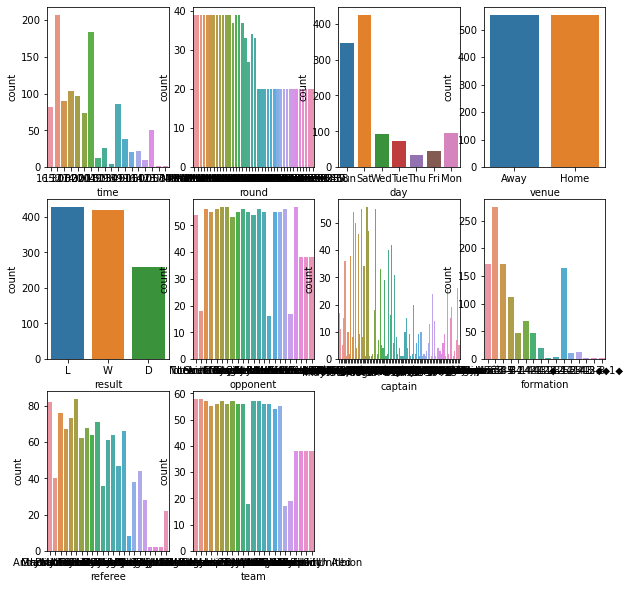

In [148]:
# Creating a list containing the names of the categorical columns
cat_cols = train.select_dtypes(include=['object']).columns

# Plotting bar charts for categorical columns on the same figure
fig = plt.figure(figsize=(10,10))
for ind, col in enumerate(cat_cols):
    ax = plt.subplot(3,4,ind+1)
    sns.countplot(x=train[col], ax=ax)
    


Observations:
- Can see a gap for the summer break in the `date` plot.
- some missing data for the `round` column needs to be explored, perhaps delayed games that hadn't been played by the time the data was scraped are causing this.
- Games are most commonly played on a Saturday or Sunday.
- There is a difference in the number of losses and wins in the dataset. This is strange as if one team wins, another has to lose. Should investigate this further.
- About a third of games end in draws.
- There are a couple more popular formations than the rest. (could turn less popular formations into 'other' category to reduce number of options in this column.
- The 2022 season is less represented in the dataset by 131 games (this is due to when the dataset was scraped).
- Some teams have roughly half the number of games in the dataset (this could be due to promotion/relegation or missing data).

Lets first look into the columns that may be effected my missing data or that raise questions, before then selecting a narrower range of categorical features and looking at if they seem to have any relation to winning or not.

Possible things to investigate:
1. Is every fixture in the dataset twice, from both teams 'perspective'?
2. Why does `round` column have missing data?
3. Why is there a difference between the number of wins and the number of losses in the dataset?
4. What are the most popular formations?

---
1. Is every fixture in the dataset twice, from both teams 'perspective'?
    - There are (10 x 38) games in a season

In [149]:
# Calculating number of games per season
games_a_season = 10 * 38
print(f'There are {games_a_season} games every season')

# Looking at how many rows in the dataset correspond to each season
print(train['season'].value_counts())

There are 380 games every season
2021    760
2022    347
Name: season, dtype: int64


Answer: Looks like every fixture is in the dataset twice, and can see we are missing more than half the season of data for the 2022 season.

---

2. Why does round column have missing data?

In [150]:
# Looking at the frequencies for each matchweek to be in the dataset
train['round'].value_counts()

Matchweek 1     39
Matchweek 8     39
Matchweek 15    39
Matchweek 14    39
Matchweek 12    39
Matchweek 11    39
Matchweek 10    39
Matchweek 9     39
Matchweek 7     39
Matchweek 6     39
Matchweek 5     39
Matchweek 4     39
Matchweek 3     39
Matchweek 2     39
Matchweek 13    37
Matchweek 16    37
Matchweek 19    34
Matchweek 20    33
Matchweek 17    33
Matchweek 18    27
Matchweek 37    20
Matchweek 36    20
Matchweek 35    20
Matchweek 34    20
Matchweek 32    20
Matchweek 31    20
Matchweek 30    20
Matchweek 28    20
Matchweek 33    20
Matchweek 27    20
Matchweek 29    20
Matchweek 26    20
Matchweek 25    20
Matchweek 24    20
Matchweek 23    20
Matchweek 22    20
Matchweek 21    20
Matchweek 38    20
Name: round, dtype: int64

Looks like there is missing data for the matchweeks, Let's look at the value counts for the different teams to see if we can explain this.

In [151]:
# Looking at the frequencies for each team in the dataset
train['team'].value_counts()

Manchester City             58
Chelsea                     58
West Ham United             57
Crystal Palace              57
Newcastle United            57
Southampton                 57
Arsenal                     57
Wolverhampton Wanderers     56
Manchester United           56
Aston Villa                 56
Leeds United                56
Brighton and Hove Albion    56
Leicester City              56
Tottenham Hotspur           55
Everton                     55
Burnley                     54
Liverpool                   38
Fulham                      38
West Bromwich Albion        38
Sheffield United            38
Norwich City                19
Brentford                   18
Watford                     17
Name: team, dtype: int64

From looking at the value counts for the different teams and using some knowledge about how the premier league works we can see that:
- The majority of teams have over 55 games in the dataset. These are teams which were in the premier league for two season.
- The rest of the teams were either promoted or relegated from the premier league at the end of the 2021 season.
    - Anomaly here as Liverpool were not relegated but have number of games in dataset to suggest that they were?
- The varying number of games played for each team is due to the data being scraped midway through the 2022 season.

Lets investigate Liverpool's missing data

In [152]:
# Investigating the data for liverpool
train[train['team'] == 'Liverpool'].season.value_counts()

2021    38
Name: season, dtype: int64

We can see that Livepool only have data for the 2021 season, therefore we can conclude that we are missing data for them in the 2022 season.

--- 

3. Why is there a difference between the number of wins and the number of losses in the dataset?

This can now be explained by the fact that we have 2 rows for every match in the dataset, one from each team's 'perspective' and because we are missing data from Liverpool in the 2022 season. Therefore the number of wins and losses in the dataset no longer match (example: if Arsenal beat liverpool in 2022 and registered a win in the dataset, there would be no row registering liverpool's perspective of a loss to match that row).

---

4. What are the most popular formations?


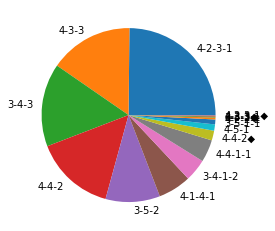

In [153]:
# Plotting a pie chart to look at the different formations used and their frequencies
plt.pie(train['formation'].value_counts(),labels=train['formation'].value_counts().index)
plt.show()

Answer: We can see that the most common formations are 4231, 433, 343 and 442.

Now that we have investigated those points we can move onto looking at some of the more relevant categorical variables and seeing if they appear to have any relation to the `win` column.

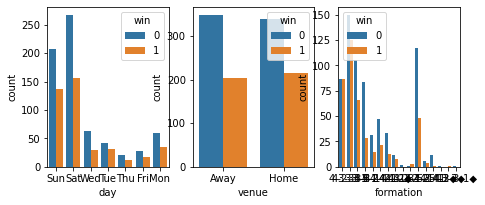

In [154]:
# Creating a lost for a subset of categorical columns to be explored further
cat_cols_subset = ['day', 'venue', 'formation']

# Plotting bar graphs for the subset of categorical columns and comparing them with the `win` column
fig = plt.figure(figsize=(10,10))
for ind, col in enumerate(cat_cols_subset):
    ax = plt.subplot(3,4,ind+1)
    sns.countplot(x=train[col], ax=ax, hue=train['win'])
    

Observations:
- We can see that the home team is more likely to win than the away team
- Some formations appear to have a significantly higher win percentage (could be down to a good team using this formation, therefore using this feature could introduce collinearity)

### 2.2 Numerical Variables

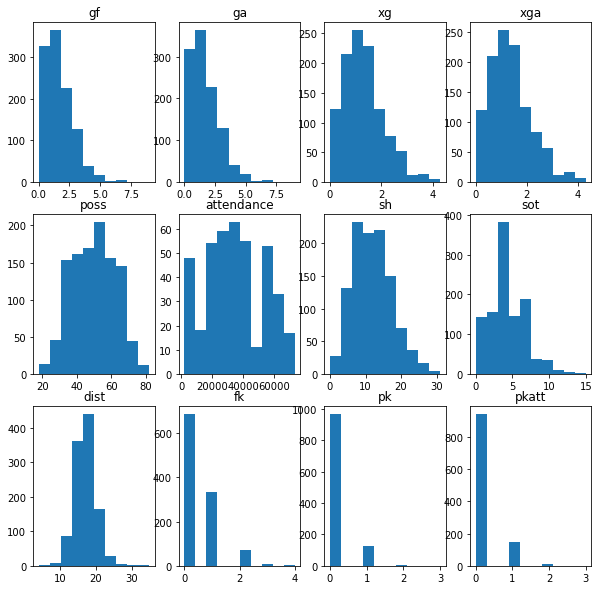

In [155]:
# Selecting all columns with float data type
num_cols = train.select_dtypes(include=['float64']).columns

# Plotting histograms for numerical features on the same figure
fig = plt.figure(figsize=(10,10))
for ind, col in enumerate(num_cols):
    ax=plt.subplot(3,4,ind+1)
    plt.hist(train[col])
    plt.title(col)

Observations:
- Everything looks normally distributed
- `gf`, `ga`, `xgf`, `xga` are all rightly skewed. As are `fk`, `pk`, `pkatt`

I am not sure whether `gf`, `ga`, `fk`, `pk`, `pkatt` should be considered numerical or categorical data. Intuitively I would say that it is numerical as there is a numerical relationship between the data points (ie 4 gf is better than 2 gf), but at the same time the range of possible values for these columns is low.

<function matplotlib.pyplot.show(close=None, block=None)>

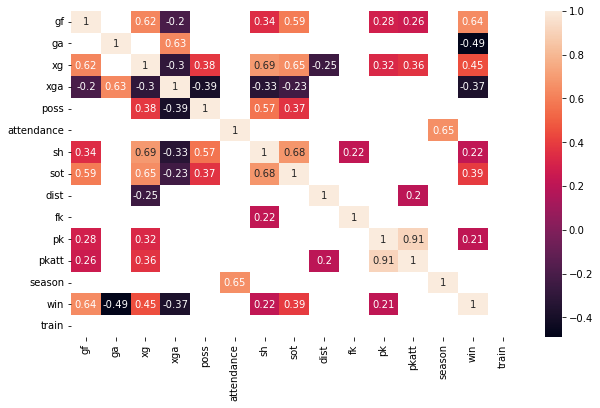

In [156]:
# Plotting a heatmap to look at correlations between the variables
correlations = train.corr()
fig = plt.figure(figsize=(10,6))
ax = sns.heatmap(correlations[abs(correlations) > 0.2], annot=True)
plt.show

Some things we can see from the heatmap above:
- `Win` has high absolute correlation with: `gf`, `ga`, `xg`, `xga`, `sh`, `sot`, `pk`.
- We see lots of correlations within different features. For example: `sh`, `sot` or `pk`, `pkatt`. We will have to think about how to deal with these features that are highly correlated.

## 3. Feature Selection

Now we will choose some features that we will use to build our baseline model.

Based of my intuition for the problem and the EDA performed above, for now we will use:
- `gf`, `ga`, `venue`, `opponent`, `formation`, `sot`, `pk`, `team` as our features and our target variable is the `win` column.


In [157]:
# Selecting features we will use as predictors for our first model
features = ['gf', 'ga', 'venue', 'opponent', 'formation', 'sot', 'pk', 'team', 'train', 'win']

all_data_subset = all_data[features]

## 4. Feature Engineering

For now I am just going to leave the features as they are to see how they work in a baseline model


## 5. Data Preprocessing

Lets preprocess the data to get it ready to be used in our model.

Note: eventually want to use the latest data for the test set, but for now will choose matches at random

In [158]:
# Creating dummy variables for categorical features
all_data_dummies = pd.get_dummies(all_data_subset, columns=['venue', 'opponent', 'formation', 'team'], drop_first=True)

In [159]:
# Splitting the data back into a train and test set
train = all_data_dummies[all_data_dummies['train'] == 1]
test = all_data_dummies[all_data_dummies['train'] == 0]

# Defining the X and y data ready for the model from the training data
y_train = train['win']
X_train = train.drop(['train', 'win'], axis=1)

# Defining the X and y data ready for the model from the test data
y_test = test['win']
X_test = test.drop(['train', 'win'], axis=1)

In [160]:
# Importing a scaler
from sklearn.preprocessing import StandardScaler

# Defining the scaler
scaler = StandardScaler()

# Fitting the scaler to the X_train data then transforming both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [161]:
# Importing a K nearest neighbours classifier
from sklearn.neighbors import KNeighborsClassifier

# Defining the model with 20 nearest neighbours, fitting the model and making a prediction on the test set
knn = KNeighborsClassifier(n_neighbors=20)
model = knn.fit(X_train_scaled, y_train)
prediction = model.predict(X_test_scaled)

In [162]:
# Checking the accuracy of the model
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, prediction)
print(f'This K nearest neighbors model with 20 neighbors has an accuracy of {acc}')

This K nearest neighbors model with 20 neighbors has an accuracy of 0.7101449275362319


# Thoughts and notes

### Extensions / improvements to project
- Incorporating more data.
- Could I make it so that it predicts the next matchweeks results based on all the results from previous matchweeks?
- could use a weighting system to favour recent results to factor in teams being on good form.


### To do list
- Do grid search to find best hyperparameters for our KNN model
- look at which features appear to have contributed most to the model (IDK how to do this yet)
- Try multiple models on the data

### My own questions/ thoughts
- How to check for features having collinearity? (formation and team?)
- In this project what is the eventual aim? Does it require me to define test and validation sets?
- How much of the experimentation and tinkering should you show in a project? for example when selecting features should you show yourself testing different features to try to come to a conclusion?
- What do you do after having built a baseline model?
- In the data every game features twice, this surely needs dealing with? how should I do it?

### How I could improve my workflow
- Add comments to data as I go
- Before doing subsequent projects, right out a general plan showing how the train, test data will be seperated and joined etc

### gaps in my knowledge
- How to evaluate a model and improve it
- How to use multiple models and compare them or use a voting system etc
